20180634_최준혁_과제3

이 자료는 2007 - 2009 사이에 Dr. Kristen Gorman가 수집한 것으로 세 종류의 남극펭귄에 대한 344개 관찰값이다.
- species: penguin species (Chinstrap, Adélie, or Gentoo)
- culmen_length_mm: culmen length (mm) 옆모습 기준 부리 가로길이
- culmen_depth_mm: culmen depth (mm) 옆모습 기준 부리 세로길이
- flipper_length_mm: flipper length (mm) 날개 길이
- body_mass_g: body mass (g) 몸무게
- island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
- sex: penguin sex

<br>남극펭귄의 서식지, 신체정보, 성별 등을 이용해 Adelie, Chinstrap, Gentoo 이상 펭귄의 세가지 종으로 구분하는 문제이다.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
penguins = sns.load_dataset("penguins")
df = penguins.copy()

In [3]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## Sample distribution

### missing values
- Missing value를 포함하는 표본을 확인한다.
- Imputation이 가능한 표본들은 남겨두고 불가능한 표본들은 삭제한다.

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


None

In [5]:
display(df.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [6]:
# Missing value Checking
for col in df.columns:
    display(df[df[col].isnull()][[col]])

,species


,island


,bill_length_mm
3,NaN
339,NaN


,bill_depth_mm
3,NaN
339,NaN


,flipper_length_mm
3,NaN
339,NaN


,body_mass_g
3,NaN
339,NaN


,sex
3,NaN
8,NaN
9,NaN
10,NaN
11,NaN
47,NaN
246,NaN
286,NaN
324,NaN
336,NaN


In [7]:
df = df.drop(index=[3,339])

In [8]:
df[(df.index == 3)|(df.index == 339)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex


- 3번,339번 이외의 펭귄은 성별만 결측치인데 나머지 신체구조 정보로 성별을 imputation할 수 있을 것이다
- 3번과 339번 펭귄은 mean등으로 신체크기를 대체하고 성별을 예측할 수 있겠지만 너무 평균 그 자체의 값이기 때문에 imputation하는 의미가 없다고 판단하여 삭제한다

In [9]:
# 혹시 모를 NAN이 아닌 Missing value Checking
for col in df.columns:
    print("-----"+str(col)+"------")
    print(df[col].value_counts(),"\n")

-----species------
Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64 

-----island------
Biscoe       167
Dream        124
Torgersen     51
Name: island, dtype: int64 

-----bill_length_mm------
41.1    7
45.2    6
39.6    5
50.5    5
50.0    5
       ..
35.6    1
36.8    1
43.1    1
38.5    1
49.9    1
Name: bill_length_mm, Length: 164, dtype: int64 

-----bill_depth_mm------
17.0    12
18.6    10
17.9    10
15.0    10
18.5    10
        ..
13.2     1
14.9     1
21.5     1
20.2     1
17.4     1
Name: bill_depth_mm, Length: 80, dtype: int64 

-----flipper_length_mm------
190.0    22
195.0    17
187.0    16
193.0    15
210.0    14
191.0    13
215.0    12
197.0    10
196.0    10
185.0     9
220.0     8
198.0     8
208.0     8
216.0     8
212.0     7
186.0     7
181.0     7
189.0     7
230.0     7
192.0     7
184.0     7
199.0     6
213.0     6
188.0     6
214.0     6
217.0     6
222.0     6
201.0     6
219.0     5
209.0     5
218.0     5
221.0     5
203.0    

### Categorical variables
- 범주형 변수들의 분포를 시각화하고 분석에서 고려해야할 특징이 있다면 해당 내용을 설명하라.

In [10]:
cat = ['sex','species', 'island']

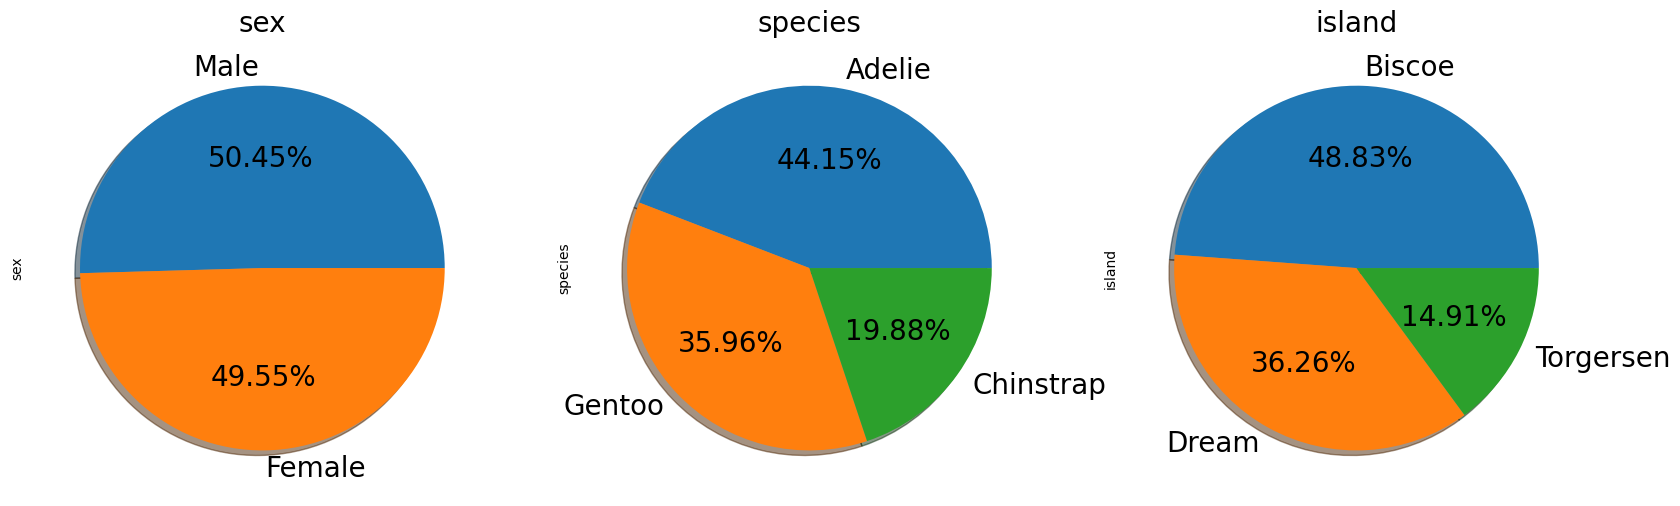

In [11]:
f, ax = plt.subplots(1, 3, figsize=(20, 15))
    
#파이차트
df['sex'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[0],shadow=True,fontsize=20)
ax[0].set_title('sex',fontsize=20)

df['species'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[1],shadow=True,fontsize=20)
ax[1].set_title('species',fontsize=20)

df['island'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[2],shadow=True,fontsize=20)
ax[2].set_title('island',fontsize=20)

plt.show()

Text(0.5, 1.0, 'Habitat of each species')

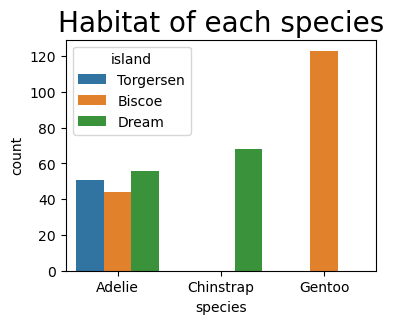

In [12]:
plt.figure(figsize=(4,3))
sns.countplot('species', hue='island', data=df)
plt.title('Habitat of each species',fontsize= 20)
# 아델리 펭귄은 골고루 서식, 친스트렙은 dream에만, 겐투는 Torgersen에만 서식

Text(0.5, 1.0, 'sex distribution by Island\n Gentoo')

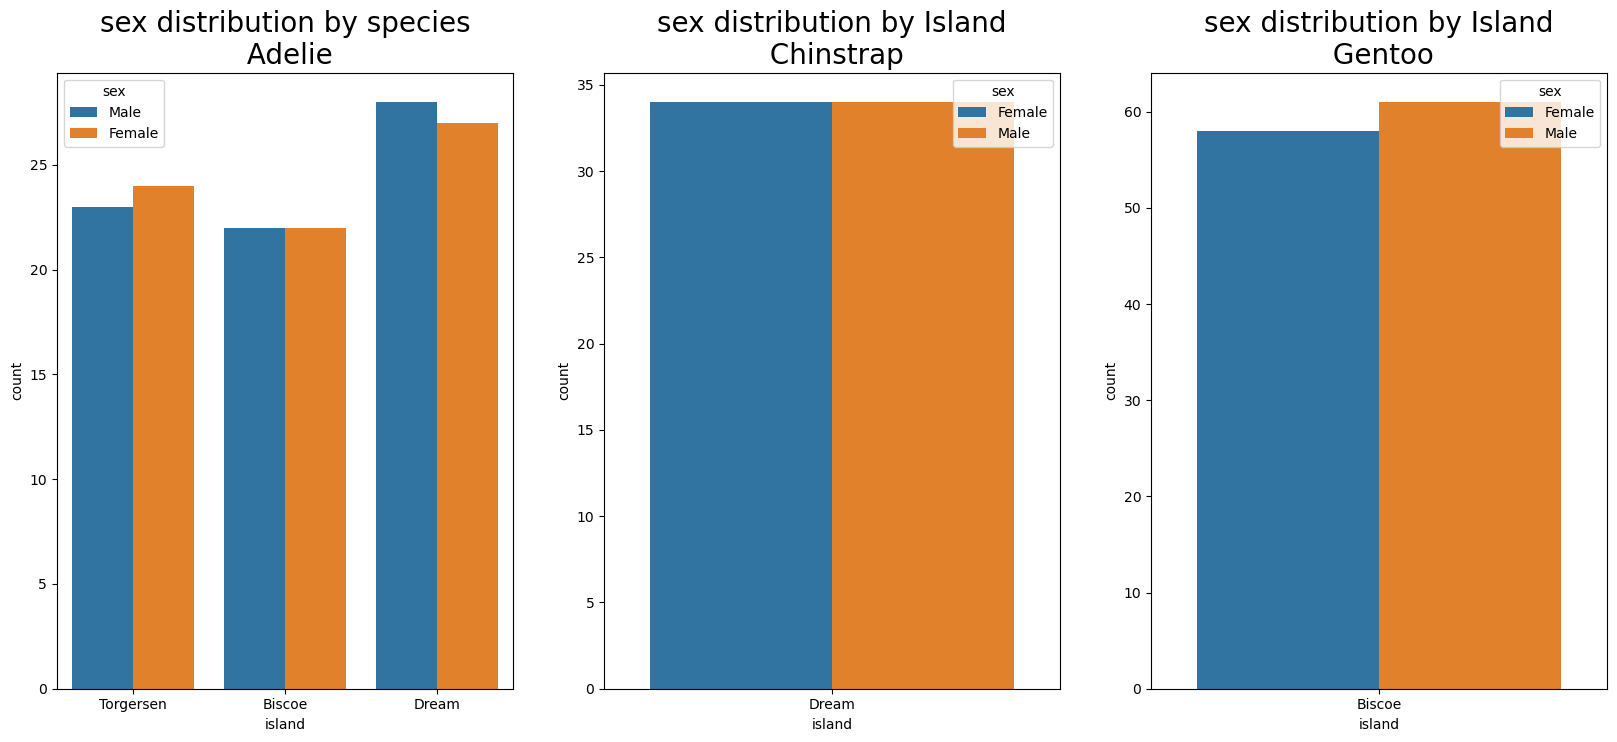

In [13]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.countplot('island', hue='sex', data=df[df['species']=='Adelie'], ax=ax[0])
ax[0].set_title('sex distribution by species\n Adelie',fontsize= 20)

sns.countplot('island', hue='sex', data=df[df['species']=='Chinstrap'], ax=ax[1])
ax[1].set_title('sex distribution by Island\n Chinstrap',fontsize= 20)

sns.countplot('island', hue='sex', data=df[df['species']=='Gentoo'], ax=ax[2])
ax[2].set_title('sex distribution by Island\n Gentoo',fontsize= 20)
# 성별 분포는 어느 종과 어느 서식지든지 모두 반반이라고 볼 수 있음

### Numerical variables
- 연속변수들의 분포를 시각화하고 어떤 특징이 있는지 설명하라.

In [14]:
ctn = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']

#### Adelie's 
bill_length_mm , bill_depth_mm , flipper_length_mm , body_mass_g

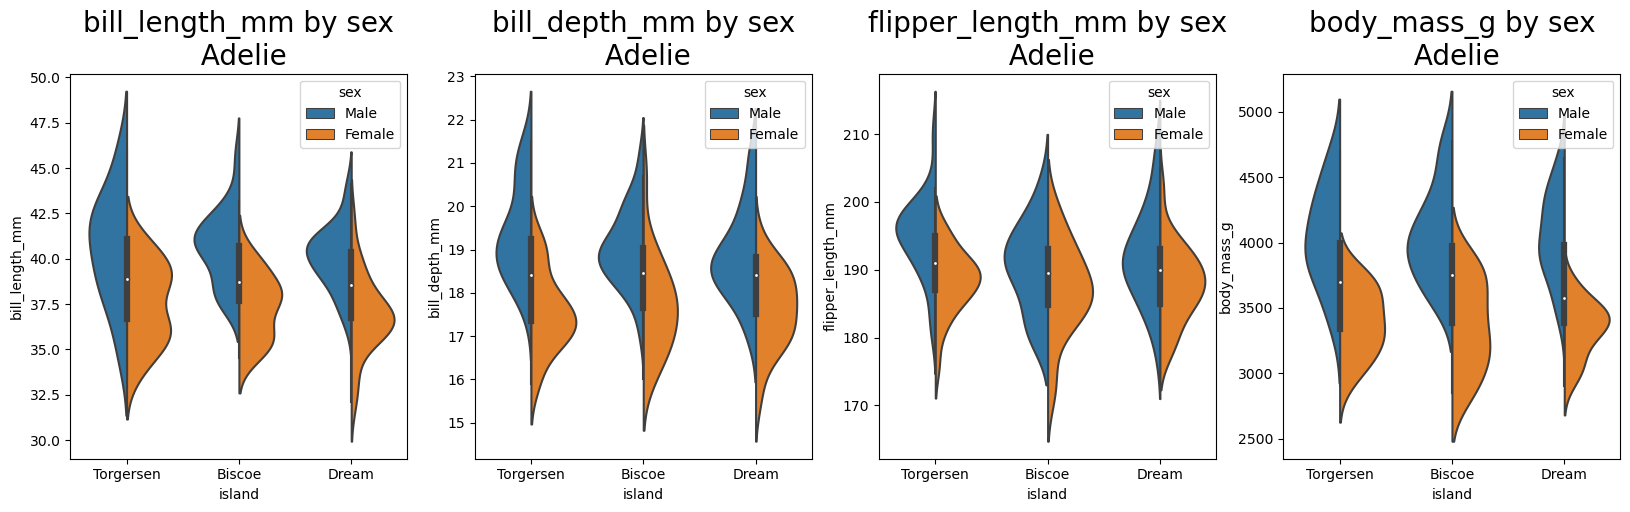

In [15]:
f, ax = plt.subplots(1, len(ctn), figsize=(20, 5))
for i in range(len(ctn)):
    sns.violinplot('island', ctn[i], hue='sex',data=df[df['species']=='Adelie'], split=True, ax= ax[i])
    ax[i].set_title(str(ctn[i])+' by sex\n Adelie',fontsize= 20)
plt.show()
# Adelie펭귄은 성별에 따라 신체부위크기(연속형변수)가 차이남
# 서식지에 따른 신체크기 차이는 크게 두드러지지는 않지만 약간씩 있음
# 두 성별 모두 연속형 변수의 분포가 서식지에 따라 다른 것을 확인 할 수 있음 
# -> 추후 성별 imputation시 아델리 펭귄은 서식지도 고려해야함.

#### Chinstrap's 
bill_length_mm , bill_depth_mm , flipper_length_mm , body_mass_g

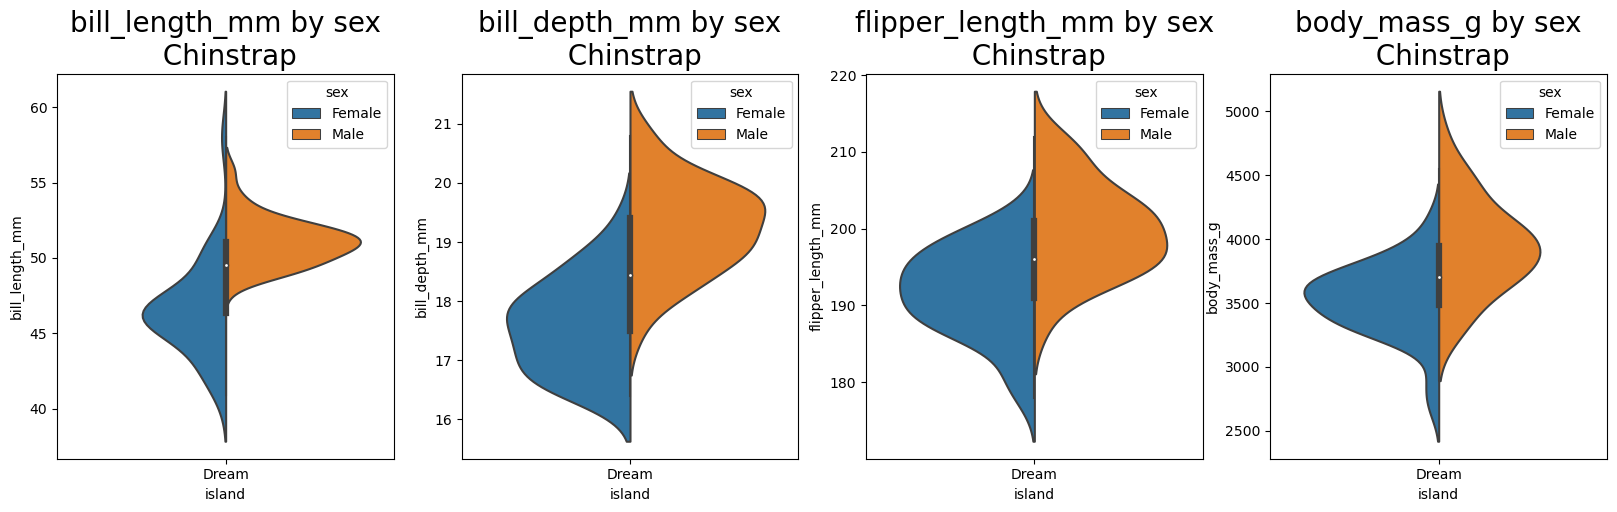

In [16]:
f, ax = plt.subplots(1, len(ctn), figsize=(20, 5))
for i in range(len(ctn)):
    sns.violinplot('island', ctn[i], hue='sex',data=df[df['species']=='Chinstrap'], split=True, ax= ax[i])
    ax[i].set_title(str(ctn[i])+' by sex\n Chinstrap',fontsize= 20)
plt.show()
# Chinstrap펭귄도 성별에 따라 신체부위크기(연속형변수)가 차이남

#### Gentoo's 
bill_length_mm , bill_depth_mm , flipper_length_mm , body_mass_g

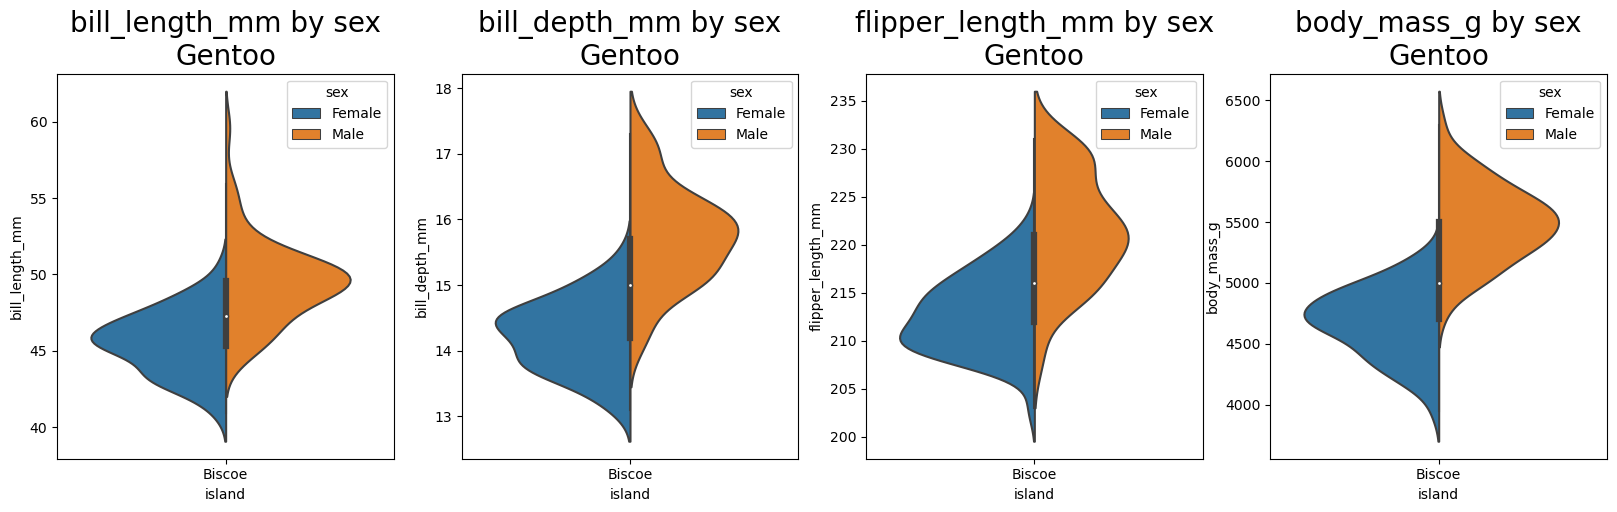

In [17]:
f, ax = plt.subplots(1, len(ctn), figsize=(20, 5))
for i in range(len(ctn)):
    sns.violinplot('island', ctn[i], hue='sex',data=df[df['species']=='Gentoo'], split=True, ax= ax[i])
    ax[i].set_title(str(ctn[i])+' by sex\nGentoo',fontsize= 20)
plt.show()
# Gentoo펭귄도 성별에 따라 신체부위크기(연속형변수)가 차이남

------------------------------------bill_length_mm----------------------------------


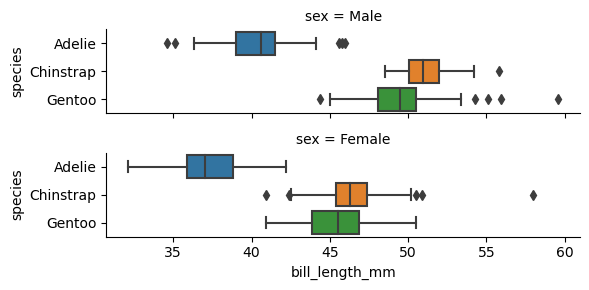





------------------------------------bill_depth_mm----------------------------------


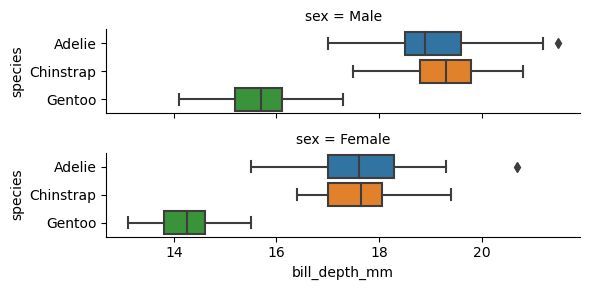





------------------------------------flipper_length_mm----------------------------------


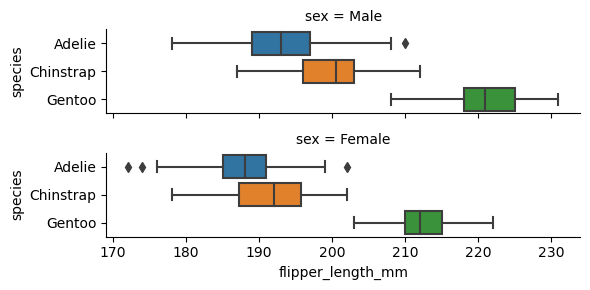





------------------------------------body_mass_g----------------------------------


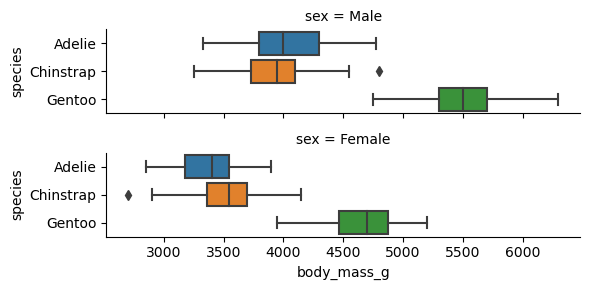

In [18]:
for i in range(len(ctn)):
    print("------------------------------------{}----------------------------------".format(ctn[i]))
    sns.catplot(ctn[i],'species',  row='sex',data=df,
               kind = 'box', orient="h", height=1.5, aspect=4)
    plt.show()
    print("\n\n\n")
# 종 별로도 신체크기 차이가 있음

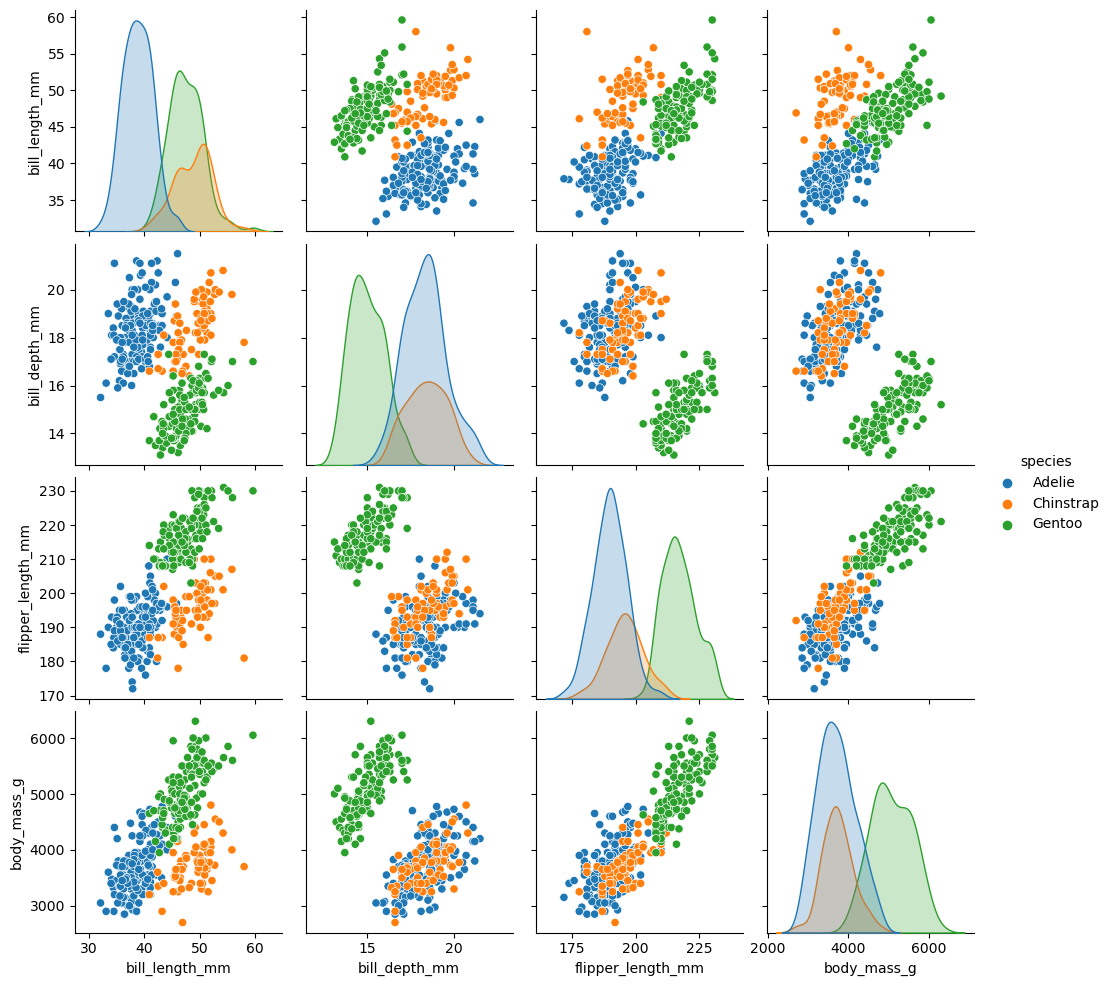

In [19]:
sns.pairplot(df, hue = 'species') 
# 종 별 신체크기 차이확인가능
# 같은 종끼리 비교했을 때 연속형 변수 간 양의 상관관계가 확인가능.ex- 몸무게가 크면 다른 신체 길이도 김

<AxesSubplot:>

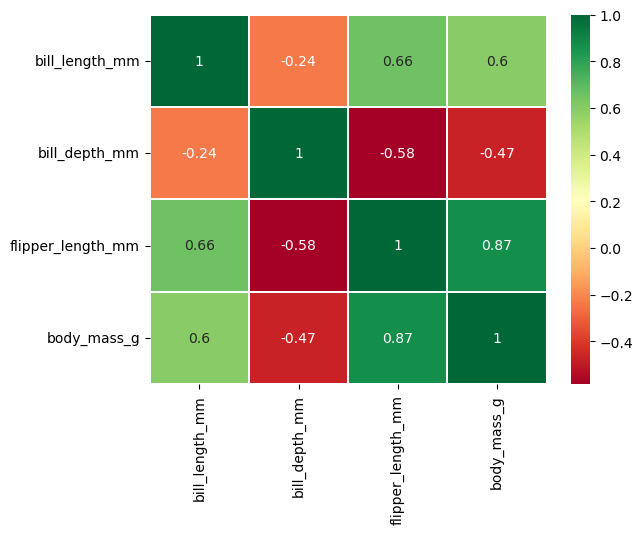

In [20]:
sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',linewidths=0.2) #다중 공선성이 걱정됨

## MICE (Multiple Imputation by Chained Equations)
- 다음 과정을 따라 missing value를 logistic regression을 이용하여 채워 넣는다.
<br> 1. 대상변수 중 missing 이 포함되지 않은 관찰값들을 이용해 모형을 추정한다.
<br> 2.추정한 모형을 이용하여 missing value에 해당하는 예측값을 구해 대체한다.
- Training 과정에서 실제값과 예측값이 일치하는 않는 관찰값은 몇개인가?
- 이 표본의 경우 logistic regression을 이용한 impuation이 MICE와 비교해 어떤 차이가 있는지 설명하라.
- 이후 분석에는 imputated data를 사용한다.

In [21]:
df.iloc[:,2:-1].head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [22]:
from sklearn.preprocessing import StandardScaler #로지스틱에 앞서 standard scale해줌

ss=StandardScaler()
ss.fit(df.iloc[:,2:-1])
df.iloc[:,2:-1]=ss.transform(df.iloc[:,2:-1])

In [23]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,-0.884499,0.785449,-1.418347,-0.564142,Male
1,Adelie,Torgersen,-0.811126,0.126188,-1.062250,-0.501703,Female
2,Adelie,Torgersen,-0.664380,0.430462,-0.421277,-1.188532,Female
4,Adelie,Torgersen,-1.324737,1.089724,-0.563715,-0.938776,Female
5,Adelie,Torgersen,-0.847812,1.748985,-0.777373,-0.689020,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,0.601305,-1.750171,0.931890,0.903175,Female
340,Gentoo,Biscoe,0.527932,-1.445897,1.003109,0.809516,Female
341,Gentoo,Biscoe,1.188289,-0.735923,1.501644,1.933419,Male
342,Gentoo,Biscoe,0.234440,-1.192335,0.789451,1.246590,Female


In [24]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le1 = le1.fit(df['island'])
df['island'] = le1.transform(df['island'])
le2 = LabelEncoder()
le2 = le2.fit(df['species'])
df['species'] = le2.transform(df['species'])
df['sex'][df['sex']=='Male'] = 1
df['sex'][df['sex']=='Female'] = 0
df = df.astype({'sex':'float64'})
df
#species Adelie Chinstrap Gentoo (012순) 
#island  Biscoe Dream Torgerson (012순) 

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.884499,0.785449,-1.418347,-0.564142,1.0
1,0,2,-0.811126,0.126188,-1.062250,-0.501703,0.0
2,0,2,-0.664380,0.430462,-0.421277,-1.188532,0.0
4,0,2,-1.324737,1.089724,-0.563715,-0.938776,0.0
5,0,2,-0.847812,1.748985,-0.777373,-0.689020,1.0
...,...,...,...,...,...,...,...
338,2,0,0.601305,-1.750171,0.931890,0.903175,0.0
340,2,0,0.527932,-1.445897,1.003109,0.809516,0.0
341,2,0,1.188289,-0.735923,1.501644,1.933419,1.0
342,2,0,0.234440,-1.192335,0.789451,1.246590,0.0


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report


In [26]:
nans = df[df['sex'].isnull()].drop(columns=['sex'])
nans #sex결측치가 있는 data들

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
8,0,2,-1.801661,0.481175,-0.563715,-0.907557
9,0,2,-0.352544,1.546135,-0.777373,0.060248
10,0,2,-1.122961,-0.025949,-1.062250,-1.126093
11,0,2,-1.122961,0.075475,-1.489566,-0.626581
47,0,1,-1.177991,0.886874,-1.560785,-1.531947
246,2,0,0.106037,-1.445897,1.074328,-0.127069
286,2,0,0.417872,-1.395184,0.931890,0.559760
324,2,0,0.619648,-1.699459,1.074328,0.653419
336,2,0,0.106037,-0.735923,1.145548,0.840736


In [27]:
new_df = df.dropna() #결측치 뺴고 로지스틱돌리기 위한 new_df
new_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.884499,0.785449,-1.418347,-0.564142,1.0
1,0,2,-0.811126,0.126188,-1.062250,-0.501703,0.0
2,0,2,-0.664380,0.430462,-0.421277,-1.188532,0.0
4,0,2,-1.324737,1.089724,-0.563715,-0.938776,0.0
5,0,2,-0.847812,1.748985,-0.777373,-0.689020,1.0
...,...,...,...,...,...,...,...
338,2,0,0.601305,-1.750171,0.931890,0.903175,0.0
340,2,0,0.527932,-1.445897,1.003109,0.809516,0.0
341,2,0,1.188289,-0.735923,1.501644,1.933419,1.0
342,2,0,0.234440,-1.192335,0.789451,1.246590,0.0


### Logistic으로 결측치 채우기
- 앞의 분포들을 살펴보았을때 서식지와 종별로 특징이 나뉘어지므로 결측치 역시 종과 서식지 별로 나누어서 예측함

#### Torgerson(2)에 사는 Adelie(0)의 성별 예측하기 

In [28]:
nans[(nans['species']==0)&(nans['island']==2)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
8,0,2,-1.801661,0.481175,-0.563715,-0.907557
9,0,2,-0.352544,1.546135,-0.777373,0.060248
10,0,2,-1.122961,-0.025949,-1.062250,-1.126093
11,0,2,-1.122961,0.075475,-1.489566,-0.626581


In [29]:
#Torgerson(2)에 사는 Adelie(0)들 데이터만 가지고 8,9,10,11의 sex를 예측
X = new_df[(new_df['species']==0)&(new_df['island']==2)].drop(columns=['sex','species','island'])
y = new_df[(new_df['species']==0)&(new_df['island']==2)]['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

lg = LogisticRegression()
lg.fit(X_train, y_train)
lg_preds = lg.predict(nans[(nans['species']==0)&(nans['island']==2)].drop(columns=['species','island']))
lg_preds

array([0., 1., 0., 0.])

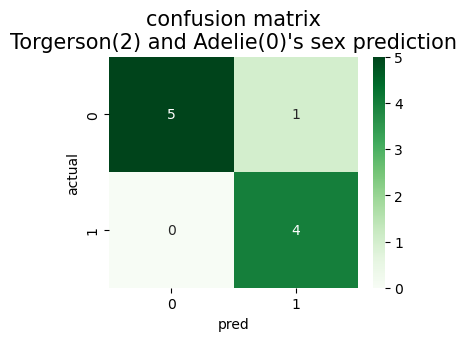

In [30]:
pred = lg.predict(X_test)
cf_matrix = confusion_matrix(y_test,pred)

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True,fmt='d',cmap = 'Greens')
plt.title('confusion matrix\nTorgerson(2) and Adelie(0)\'s sex prediction',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show() # 예측값과 실제값 1개 틀림

#### Dream(1)에 사는 Adelie(0)의 성별 예측하기 

In [31]:
nans[(nans['species']==0)&(nans['island']==1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
47,0,1,-1.177991,0.886874,-1.560785,-1.531947


In [32]:
#Dream(1)에 사는 Adelie(0)들 데이터만 가지고 47의 sex를 예측
X = new_df[(new_df['species']==0)&(new_df['island']==1)].drop(columns=['sex'])
y = new_df[(new_df['species']==0)&(new_df['island']==1)]['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

lg = LogisticRegression()
lg.fit(X_train, y_train)
lg_preds = lg.predict(nans[(nans['species']==0)&(nans['island']==1)])
lg_preds

array([0.])

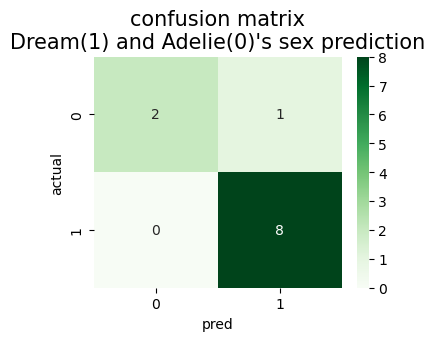

In [33]:
pred = lg.predict(X_test)
cf_matrix = confusion_matrix(y_test,pred)

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True,fmt='d',cmap = 'Greens')
plt.title('confusion matrix\nDream(1) and Adelie(0)\'s sex prediction',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show() #예측값과 실제값 1개 틀림

#### Biscoe(0)에 사는 Gentoo(2)의 성별 예측하기 

In [34]:
nans[(nans['species']==2)&(nans['island']==0)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
246,2,0,0.106037,-1.445897,1.074328,-0.127069
286,2,0,0.417872,-1.395184,0.931890,0.559760
324,2,0,0.619648,-1.699459,1.074328,0.653419
336,2,0,0.106037,-0.735923,1.145548,0.840736


In [35]:
# Biscoe(0)에 사는 Gentoo(2)들 데이터만 가지고 47의 sex를 예측
X = new_df[(new_df['species']==2)&(new_df['island']==0)].drop(columns=['sex'])
y = new_df[(new_df['species']==2)&(new_df['island']==0)]['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

lg = LogisticRegression()
lg.fit(X_train, y_train)
lg_preds = lg.predict(nans[(nans['species']==2)&(nans['island']==0)])
lg_preds

array([0., 0., 0., 0.])

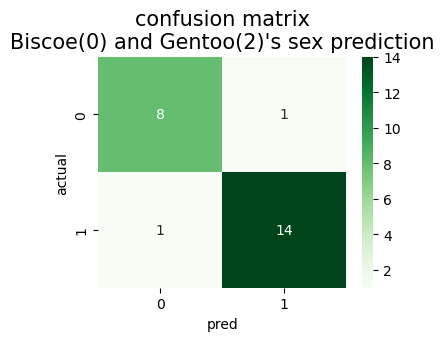

In [36]:
pred = lg.predict(X_test)
cf_matrix = confusion_matrix(y_test,pred)

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True,fmt='d',cmap = 'Greens')
plt.title('confusion matrix\nBiscoe(0) and Gentoo(2)\'s sex prediction',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show() #예측값과 실제값 2개 틀림

#### logistic으로 예측한 값으로 결측 값 대체

In [37]:
mice_df = df.copy()
mice_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.884499,0.785449,-1.418347,-0.564142,1.0
1,0,2,-0.811126,0.126188,-1.062250,-0.501703,0.0
2,0,2,-0.664380,0.430462,-0.421277,-1.188532,0.0
4,0,2,-1.324737,1.089724,-0.563715,-0.938776,0.0
5,0,2,-0.847812,1.748985,-0.777373,-0.689020,1.0


In [38]:
nan_index= [8,9,10,11,47,246,286,324,336]

In [39]:
# Torgerson(2)에 살고 Adelie(0)인 결측치 성별 예측값으로 대체
df.loc[8,'sex'] = 0
df.loc[9,'sex'] = 1
df.loc[10,'sex'] = 0
df.loc[11,'sex'] = 0

In [40]:
# Dream(1)에 살고 Adelie(0)인 결측치 성별 예측값으로 대체
df.loc[47,'sex'] = 0

In [41]:
# Biscoe(0)에 살고 Gentoo(2)인 결측치 성별 예측값으로 대체
df.loc[246,'sex'] = 0
df.loc[286,'sex'] = 0
df.loc[324,'sex'] = 0
df.loc[336,'sex'] = 0

In [42]:
print(df.isnull().sum())
display(df)

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.884499,0.785449,-1.418347,-0.564142,1.0
1,0,2,-0.811126,0.126188,-1.062250,-0.501703,0.0
2,0,2,-0.664380,0.430462,-0.421277,-1.188532,0.0
4,0,2,-1.324737,1.089724,-0.563715,-0.938776,0.0
5,0,2,-0.847812,1.748985,-0.777373,-0.689020,1.0
...,...,...,...,...,...,...,...
338,2,0,0.601305,-1.750171,0.931890,0.903175,0.0
340,2,0,0.527932,-1.445897,1.003109,0.809516,0.0
341,2,0,1.188289,-0.735923,1.501644,1.933419,1.0
342,2,0,0.234440,-1.192335,0.789451,1.246590,0.0


### mice로 결측치 채우기

In [43]:
from impyute.imputation.cs import mice
mice_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.884499,0.785449,-1.418347,-0.564142,1.0
1,0,2,-0.811126,0.126188,-1.062250,-0.501703,0.0
2,0,2,-0.664380,0.430462,-0.421277,-1.188532,0.0
4,0,2,-1.324737,1.089724,-0.563715,-0.938776,0.0
5,0,2,-0.847812,1.748985,-0.777373,-0.689020,1.0


#### Torgerson(2)에 사는 Adelie(0)의 성별 예측하기 

In [44]:
temp=mice_df[(mice_df['species']==0)&(mice_df['island']==2)]
imputed_training = mice(temp.values)
mice02 = pd.DataFrame(imputed_training)
mice02.index = temp.index; mice02. columns = temp.columns
mice02['sex']

for i in nan_index:
    try: print(i,' : ', mice02.loc[i,'sex'])
    except : continue

8  :  0.18379663216825193
9  :  1.0496099983513965
10  :  0.024150617569896227
11  :  0.13729678477325624


#### Dream(1)에 사는 Adelie(0)의 성별 예측하기 

In [45]:
temp=mice_df[(mice_df['species']==0)&(mice_df['island']==1)]
imputed_training = mice(temp.values)
mice01 = pd.DataFrame(imputed_training)
mice01.index = temp.index; mice01. columns = temp.columns
mice01['sex']

for i in nan_index:
    try: print(i,' : ', mice01.loc[i,'sex'])
    except : continue

47  :  0.014595792527889673


#### Biscoe(0)에 사는 Gentoo(2)의 성별 예측하기

In [46]:
temp=mice_df[(mice_df['species']==2)&(mice_df['island']==0)]
imputed_training = mice(temp.values)
mice20 = pd.DataFrame(imputed_training)
mice20.index = temp.index; mice20. columns = temp.columns
mice20['sex']

for i in nan_index:
    try: print(i,' : ', mice20.loc[i,'sex'])
    except : continue

246  :  -0.1295729487277273
286  :  0.16873612734218757
324  :  0.12816770280417306
336  :  0.4889659726972485


#### mice와 비교하기

In [47]:
print('------logistic 예측------')
for i in nan_index:
    try: print(i,' : ', df.loc[i,'sex'])
    except : continue

------logistic 예측------
8  :  0.0
9  :  1.0
10  :  0.0
11  :  0.0
47  :  0.0
246  :  0.0
286  :  0.0
324  :  0.0
336  :  0.0


In [48]:
print('------ㅡmice 예측(원자료)------')
micelist = [mice02, mice01, mice20]
for mice in micelist:
    for i in nan_index:
        try: print(i,' : ', mice.loc[i,'sex'])
        except : continue

------ㅡmice 예측(원자료)------
8  :  0.18379663216825193
9  :  1.0496099983513965
10  :  0.024150617569896227
11  :  0.13729678477325624
47  :  0.014595792527889673
246  :  -0.1295729487277273
286  :  0.16873612734218757
324  :  0.12816770280417306
336  :  0.4889659726972485


In [49]:
print('------ㅡmice 예측(반올림)------')
micelist = [mice02, mice01, mice20]
for mice in micelist:
    for i in nan_index:
        try: print(i,' : ', round(mice.loc[i,'sex']))
        except : continue

------ㅡmice 예측(반올림)------
8  :  0
9  :  1
10  :  0
11  :  0
47  :  0
246  :  0
286  :  0
324  :  0
336  :  0


- mice와 logistic은 이 자료에서 예측한 결측치가 같다

## Logistic regression
- Training set과 test set으로 구분한 후 statsmodels의 MultinomialModel로 성별을 식별하는 모형을 훈련시켜 confusion matrix를 계산한다.
- 다중공선성문제로 제대로된 추정결과를 얻기 어려우므로 fit_regularized(alpha=0)를 사용한다.
- Penalty의 가중값을 0으로 둔 표준모형이지만 추정값 계산이 가능하다.
- 추정계수가 해석이 가능한지, 가능하다면 어떻게 해석해야 하는지 설명하라.

In [50]:
X = df.drop(columns=['sex'])
y = df['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

MNLogit = sm.MNLogit(y_train, X_train, check_rank=True)
result = MNLogit.fit_regularized(alpha=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24282853145301614
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38


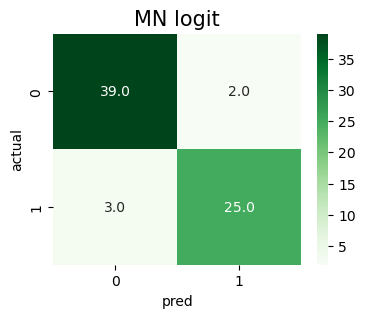

In [51]:
pred_df = result.predict(X_test)[[1]]
pred_df[pred_df>=0.5] = 1
pred_df[pred_df <0.5]= 0

cf_matrix = confusion_matrix(y_test,pred_df)

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True,fmt='.1f',cmap = 'Greens')
plt.title('MN logit',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show()

In [52]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                    sex   No. Observations:                  273
Model:                        MNLogit   Df Residuals:                      267
Method:                           MLE   Df Model:                            5
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.6494
Time:                        23:50:50   Log-Likelihood:                -66.292
converged:                       True   LL-Null:                       -189.08
Covariance Type:            nonrobust   LLR p-value:                 4.886e-51
=====================================================================================
            sex=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
species              -0.4806      0.330     -1.458      0.145      -1.127       0.165
island                0.5032      0.395      1.275      0.202      -0.271       1.277
bill_length_mm        0.6884      0.327      2.104      0.035       0.047       1.330
bill_depth_mm         3.5429      0.558      6.354      0.000       2.450       4.636
flipper_length_mm    -0.6492      0.539     -1.205      0.228      -1.705       0.406
body_mass_g           4.6194      0.765      6.041      0.000       3.121       6.118
=====================================================================================
"""

- 추정계수 해석하기
<br> 본 과제에서는 onehotencoding이 아닌 label인코딩을 하여 종과 섬의 계수는 해석할 수 없다.(logistic regression이므로)
<br> p-value를 보면 연속형 변수들이 flipper_length_mm제외하고 5%수준에서 유의함을 알 수 있다. 이들의 계수가 의미하는 것은 다음과 같다
<br> bill_length_mm, bill_depth_mm, body_mass_g는 성별이 수컷이면 좀더 높은 경향이 있다.
<br> 각 추정계수를 지수변환을 하여 확률 비율의 변화로 해석할 수 있다.

## Regulaized logistic regression

### L2 Ridge
- Training set과 test set으로 구분한 후 sklearn의 LogisticRegression으로 성별을 식별하는 분류기를 훈련하고 confusion matrix로 성과를 정리한다.
- 모든 keyword option은 default 값을 사용한다. penalty='l2', C=1.0, solver='lbfgs'

accuracy_score :  0.8985507246376812
precision_score :  0.8787878787878788
recall_score :  0.90625
f1_score :  0.8923076923076922


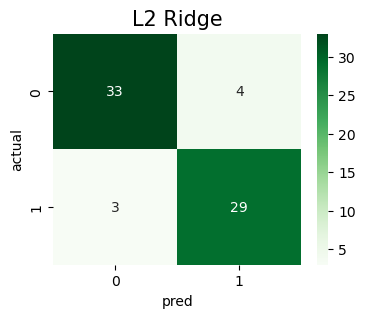

In [53]:
X = df.drop(columns=['sex'])
y = df['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=te = 123)

lg = LogisticRegression()
lg.fit(X_train, y_train)
pred = lg.predict(X_test)
cf_matrix = confusion_matrix(y_test,pred)

print('accuracy_score : ',accuracy_score(y_test,pred))
print('precision_score : ',precision_score(y_test,pred))
print('recall_score : ',recall_score(y_test,pred))
print('f1_score : ',f1_score(y_test,pred))

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True,fmt='d',cmap = 'Greens')
plt.title('L2 Ridge',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show()

### L1 Lasso
- L1 LogisticRegression에 사용할 수 있는 optimization algorithm은 제한이 되어 있다.
- GridSearchCV을 이용해 사용가능한 모든 algorithm과 다양한 C값으로 추정하고 최적모형을 선택한다.
- scoring으로 두개 이상의 loss function을 사용하고 결과를 비교한다.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [55]:
X = df.drop(columns=['sex'])
y = df['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 150)
grid_values = {'penalty': ['l1'], 'C': [0.0001 ,0.001, 0.01, 0.1,0,1, 10, 100],
               'solver': ['liblinear','saga'], 'multi_class':['ovr','multinomial']}

lasso = LogisticRegression()

#### scoring = 'average_precision'

In [56]:
gridSearch = GridSearchCV(lasso, param_grid = grid_values,cv=10, scoring='average_precision')
gridSearch.fit(X_train,y_train)
print('-----< average_precision >-----')
print(gridSearch.best_params_)
print(gridSearch.best_score_)

-----< average_precision >-----
{'C': 100, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
0.9826842083435489


In [57]:
gridSearch = GridSearchCV(lasso, param_grid = grid_values,cv=10, scoring='roc_auc')
gridSearch.fit(X_train,y_train)
print('-----< average_precision >-----')
print(gridSearch.best_params_)
print(gridSearch.best_score_)

-----< average_precision >-----
{'C': 100, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
0.9824568288854003


In [58]:
c = gridSearch.best_params_['C']
c

100

In [59]:
gridSearch.best_score_ 

0.9824568288854003

### Solver 에 따른 차이
- L1 penalty와 함께 사용할 수 있는 solver의 특징을 요약하고 solver에 따른 성과를 비교하라.

In [60]:
'liblinear', 'saga'

('liblinear', 'saga')

#### 'liblinear', 'saga'
- L1과 함께 쓸 수 있는 것은 다음 두가지 solver이다

##### 'liblinear'
- 이 solver는 L1, l2모두 지원하며 데이터의 크기가 작은 데이터에 적합한 특징이 있다

#####  'saga'
- 이 solver는 L1만지원하며 확률적 경사하강법을 기반으로 하기 때문에 대용량 데이터에 적합하다

accuracy_score :  0.8405797101449275
precision_score :  0.875
recall_score :  0.8
f1_score :  0.8358208955223881


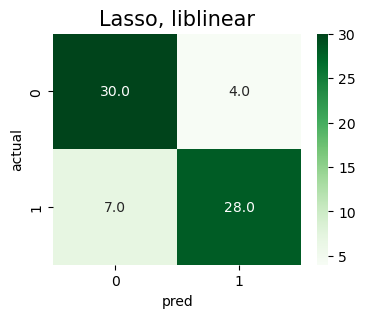

In [61]:
lasso1 = LogisticRegression(penalty = 'l1',C = c, solver = 'liblinear', multi_class = 'ovr')
lasso1.fit(X_train, y_train)
pred1 = lasso1.predict(X_test)
cf_matrix1 = confusion_matrix(y_test,pred1)
print('accuracy_score : ',accuracy_score(y_test,pred1))
print('precision_score : ',precision_score(y_test,pred1))
print('recall_score : ',recall_score(y_test,pred1))
print('f1_score : ',f1_score(y_test,pred1))

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix1, annot=True,fmt='.1f',cmap = 'Greens')
plt.title('Lasso, liblinear',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')
plt.show()

accuracy_score :  0.8405797101449275
precision_score :  0.875
recall_score :  0.8
f1_score :  0.8358208955223881


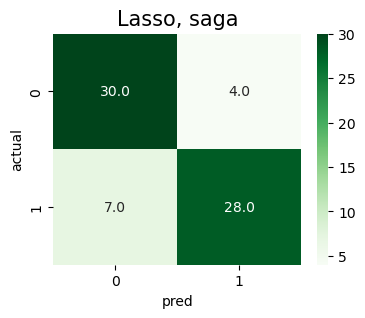

In [62]:
lasso2= LogisticRegression(penalty = 'l1',C =c, solver = 'saga', multi_class = 'ovr')
lasso2.fit(X_train, y_train)
pred2 = lasso2.predict(X_test)
cf_matrix2 = confusion_matrix(y_test,pred2)

print('accuracy_score : ',accuracy_score(y_test,pred2))
print('precision_score : ',precision_score(y_test,pred2))
print('recall_score : ',recall_score(y_test,pred2))
print('f1_score : ',f1_score(y_test,pred2))

plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix2, annot=True,fmt='.1f',cmap = 'Greens')
plt.title('Lasso, saga',fontsize= 15)
plt.xlabel('pred') ; plt.ylabel('actual')

plt.show()